In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


import os

os.environ["R_HOME"] = "/root/miniconda3/envs/R/lib/R"

import rpy2.robjects as objects
from rpy2.robjects.packages import importr

base = importr("base")
r_pROC = importr("pROC")
base._libPaths()[0]


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(
        list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"]
    )
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_186705/1622204394.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [2]:
# this is muse_xml_to_array.py
# Input a directory of XML files, get a directory of np arrays where each .npy is a 12-lead ecg shape 2500,12,1. So this gives you JUST the waveforms
# Some notes, the unique ECG ID index key used in MUSE backend does not exist in the XML at least for us, so instead we use MRN_AcquisitionDTTM_PharmaUniqueECGID

# In terminal run python3 muse_xml_to_array.py <LOCATION_OF_XML_FILES>

import argparse
import base64
import os
import struct
import sys

import numpy as np
import pandas as pd
import xmltodict


def file_path(path):
    filepath = path
    for dirName, subdirList, fileList in os.walk(filepath):
        for filename in fileList:
            if ".xml" in filename.lower():
                ekg_file_list.append(os.path.join(dirName, filename))


# need to update this function to check the output directory for the output file and then only on newly added EKGs
# add timestamp to start file string
# this is annoying because the XML file name is a random timestamp and the output file is the UniqueECGID


if not os.path.exists(os.getcwd() + "/ekg_waveforms_output/"):
    os.mkdir(os.getcwd() + "/ekg_waveforms_output/")

# parser = argparse.ArgumentParser(description='Input and outputs for XML EKG parsing')
# parser.add_argument('input', type=str)
# parser.set_defaults(output=os.getcwd() + '/ekg_waveforms_output/') #ensure this directory already exists

# args = parser.parse_args()


def decode_ekg_muse(raw_wave):
    """
    Ingest the base64 encoded waveforms and transform to numeric
    """
    # covert the waveform from base64 to byte array
    arr = base64.b64decode(bytes(raw_wave, "utf-8"))

    # unpack every 2 bytes, little endian (16 bit encoding)
    unpack_symbols = "".join([char * (len(arr) // 2) for char in "h"])
    byte_array = struct.unpack(unpack_symbols, arr)
    return byte_array


def decode_ekg_muse_to_array(raw_wave, downsample=1):
    """
    Ingest the base64 encoded waveforms and transform to numeric

    downsample: 0.5 takes every other value in the array. Muse samples at 500/s and the sample model requires 250/s. So take every other.
    """
    try:
        dwnsmpl = int(1 // downsample)
    except ZeroDivisionError:
        print("You must downsample by more than 0")
    # covert the waveform from base64 to byte array
    arr = base64.b64decode(bytes(raw_wave, "utf-8"))

    # unpack every 2 bytes, little endian (16 bit encoding)
    unpack_symbols = "".join([char * int(len(arr) / 2) for char in "h"])
    byte_array = struct.unpack(unpack_symbols, arr)
    return np.array(byte_array)[::dwnsmpl]


def xml_to_np_array_file(path_to_xml, path_to_output=os.getcwd()):

    with open(path_to_xml, "rb") as fd:
        dic = xmltodict.parse(fd.read().decode("utf8"))

    """
    
    Upload the ECG as numpy array with shape=[2500,12,1] ([time, leads, 1]).

    The voltage unit should be in 1 mv/unit and the sampling rate should be 250/second (total 10 second).

    The leads should be ordered as follow I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6.

    """
    # print(dic)
    try:
        pt_id = dic["RestingECG"]["PatientDemographics"]["PatientID"]
    except:
        print("no PatientID")
        pt_id = "none"
    try:
        AcquisitionDateTime = (
            dic["RestingECG"]["TestDemographics"]["AcquisitionDate"]
            + "_"
            + dic["RestingECG"]["TestDemographics"]["AcquisitionTime"].replace(":", "-")
        )
    except:
        print("no AcquisitionDateTime")
        AcquisitionDateTime = "none"

    # try:
    #     requisition_number = dic['RestingECG']['Order']['RequisitionNumber']
    # except:
    #     print("no requisition_number")
    #     requisition_number = "none"

    # need to instantiate leads in the proper order for the model
    lead_order = [
        "I",
        "II",
        "III",
        "aVR",
        "aVL",
        "aVF",
        "V1",
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
    ]

    """
    Each EKG will have this data structure:
    lead_data = {
        'I': np.array
    }
    """

    lead_data = dict.fromkeys(lead_order)
    # lead_data = {leadid: None for k in lead_order}

    #     for all_lead_data in dic['RestingECG']['Waveform']:
    #         for single_lead_data in lead['LeadData']:
    #             leadname =  single_lead_data['LeadID']
    #             if leadname in (lead_order):
    #try:
    for lead in dic["RestingECG"]["Waveform"]:
        for leadid in range(len(lead["LeadData"])):
            sample_length = len(
                decode_ekg_muse_to_array(lead["LeadData"][leadid]["WaveFormData"])
            )
            # sample_length is equivalent to dic['RestingECG']['Waveform']['LeadData']['LeadSampleCountTotal']
            if sample_length == 5000:
                lead_data[
                    lead["LeadData"][leadid]["LeadID"]
                ] = decode_ekg_muse_to_array(
                    lead["LeadData"][leadid]["WaveFormData"], downsample=0.5
                )
            elif sample_length == 2500:
                lead_data[
                    lead["LeadData"][leadid]["LeadID"]
                ] = decode_ekg_muse_to_array(
                    lead["LeadData"][leadid]["WaveFormData"], downsample=1
                )
            else:
                continue
        # ensures all leads have 2500 samples and also passes over the 3 second waveform

    lead_data["III"] = np.array(lead_data["II"]) - np.array(lead_data["I"])
    lead_data["aVR"] = -(np.array(lead_data["I"]) + np.array(lead_data["II"])) / 2
    lead_data["aVF"] = (np.array(lead_data["II"]) + np.array(lead_data["III"])) / 2
    lead_data["aVL"] = (np.array(lead_data["I"]) - np.array(lead_data["III"])) / 2

    lead_data = {k: lead_data[k] for k in lead_order}
    # drops V3R, V4R, and V7 if it was a 15-lead ECG

    # now construct and reshape the array
    # converting the dictionary to an np.array
    temp = []
    for key, value in lead_data.items():
        temp.append(value)

    # transpose to be [time, leads, ]
    ekg_array = np.array(temp).T

    # expand dims to [time, leads, 1]
    ekg_array = np.expand_dims(ekg_array, axis=-1)

    # Here is a check to make sure all the model inputs are the right shape
    #     assert ekg_array.shape == (2500, 12, 1), "ekg_array is shape {} not (2500, 12, 1)".format(ekg_array.shape )

    # filename = '/ekg_waveform_{}_{}.npy'.format(pt_id, requisition_number)
    filename = f"{pt_id}_{AcquisitionDateTime}.npy"

    path_to_output += filename
    # print(path_to_output)
    with open(path_to_output, "wb") as f:
        np.save(f, ekg_array)
    return path_to_output

    #except:
    #    print("error", dic)
    #    return None


def ekg_batch_run(ekg_list):
    i = 0
    x = 0
    for file in ekg_list:
        try:
            xml_to_np_array_file(file, output_dir)
            i += 1
        except Exception as e:
            # print("file failed: ", file)
            print(file, e)
            x += 1
        if i % 10000 == 0:
            print(f"Succesfully converted {i} EKGs, failed converting {x} EKGs")

In [3]:
def generate_ecg_dataframe_and_npy(df, output_dir="/ekg_waveforms_output/"):
    output_dir = os.getcwd() + output_dir

    from ECGXMLReader import ECGXMLReader
    from tqdm import tqdm

    patientid_list = []
    patientage_list = []
    patient_date_of_birth_list = []
    patient_gender_list = []
    patient_VentricularRate_list = []
    patient_AtrialRate_list = []
    patient_PRInterval_list = []
    patient_QRSDuration_list = []
    patient_QTInterval_list = []
    patient_QTCorrected_list = []
    patient_Paxis_list = []
    patient_Raxis_list = []
    patient_TAxis_list = []
    patient_QRSCount_list = []
    patient_QOnset_list = []
    patient_QOffset_list = []
    patient_POnset_list = []
    patient_POffset_list = []
    patient_TOffset_list = []
    patient_ECGSampleBase_list = []
    patient_ECGSampleExponent_list = []
    patient_QTcFrederica_list = []
    patient_Location_list = []
    patient_LocatioName_list = []
    patient_RoomID_list = []
    patient_acquisitiondate_list = []
    patient_acquisitiontime_list = []
    patient_status_list = []
    patient_acquisitiondevice_list = []
    patient_referringMDLastName_list = []
    patient_AnalysisSoftware_list = []
    patient_acquisitionSoftwareVersion_list = []
    diagnosis_list = []
    original_diagnosis_list = []
    ecg_output_path_list = []
    xml_path_list = []

    for index, row in tqdm(df.iterrows()):
        ecg = ECGXMLReader(row["path"], augmentLeads=True)
        xml_path_list.append(row["path"])
        patientid_list.append(ecg.PatientDemographics["PatientID"])

        try:
            patientage_list.append(ecg.PatientDemographics["PatientAge"])
        except:
            patientage_list.append(np.nan)

        try:
            patient_date_of_birth_list.append(ecg.PatientDemographics["DateofBirth"])
        except:
            patient_date_of_birth_list.append(np.nan)
        try:
            patient_gender_list.append(ecg.PatientDemographics["Gender"])
        except:
            patient_gender_list.append(np.nan)

        try:
            patient_VentricularRate_list.append(
                ecg.RestingECGMeasurements["VentricularRate"]
            )
        except:
            patient_VentricularRate_list.append(np.nan)

        try:
            patient_AtrialRate_list.append(ecg.RestingECGMeasurements["AtrialRate"])
        except:
            patient_AtrialRate_list.append(np.nan)
        try:
            patient_PRInterval_list.append(ecg.RestingECGMeasurements["PRInterval"])
        except:
            patient_PRInterval_list.append(np.nan)
        try:
            patient_QRSDuration_list.append(ecg.RestingECGMeasurements["QRSDuration"])
        except:
            patient_QRSDuration_list.append(np.nan)
        try:
            patient_QTInterval_list.append(ecg.RestingECGMeasurements["QTInterval"])
        except:
            patient_QTInterval_list.append(np.nan)

        try:
            patient_QTCorrected_list.append(ecg.RestingECGMeasurements["QTCorrected"])
        except:
            patient_QTCorrected_list.append(np.nan)
        try:
            patient_Paxis_list.append(ecg.RestingECGMeasurements["PAxis"])
        except:
            patient_Paxis_list.append(np.nan)

        try:
            patient_Raxis_list.append(ecg.RestingECGMeasurements["RAxis"])
        except:
            patient_Raxis_list.append(np.nan)
        try:
            patient_TAxis_list.append(ecg.RestingECGMeasurements["TAxis"])
        except:
            patient_TAxis_list.append(np.nan)

        try:
            patient_QRSCount_list.append(ecg.RestingECGMeasurements["QRSCount"])
        except:
            patient_QRSCount_list.append(np.nan)
        try:
            patient_QOnset_list.append(ecg.RestingECGMeasurements["QOnset"])
        except:
            patient_QOnset_list.append(np.nan)

        try:
            patient_QOffset_list.append(ecg.RestingECGMeasurements["QOffset"])
        except:
            patient_QOffset_list.append(np.nan)
        try:
            patient_POnset_list.append(ecg.RestingECGMeasurements["POnset"])
        except:
            patient_POnset_list.append(np.nan)
        try:
            patient_POffset_list.append(ecg.RestingECGMeasurements["POffset"])
        except:
            patient_POffset_list.append(np.nan)
        try:
            patient_TOffset_list.append(ecg.RestingECGMeasurements["TOffset"])
        except:
            patient_TOffset_list.append(np.nan)

        patient_ECGSampleBase_list.append(ecg.RestingECGMeasurements["ECGSampleBase"])
        patient_ECGSampleExponent_list.append(
            ecg.RestingECGMeasurements["ECGSampleExponent"]
        )
        try:
            patient_QTcFrederica_list.append(ecg.RestingECGMeasurements["QTcFrederica"])
        except:
            patient_QTcFrederica_list.append(np.nan)

        patient_Location_list.append(ecg.TestDemographics["Location"])

        try:
            patient_LocatioName_list.append(ecg.TestDemographics["LocationName"])
        except:
            patient_LocatioName_list.append(np.nan)

        try:
            patient_RoomID_list.append(ecg.TestDemographics["RoomID"])
        except:
            patient_RoomID_list.append("None")
        try:
            patient_acquisitiondate_list.append(ecg.TestDemographics["AcquisitionDate"])
        except:
            patient_acquisitiondate_list.append(np.nan)

        try:
            patient_acquisitiontime_list.append(ecg.TestDemographics["AcquisitionTime"])
        except:
            patient_acquisitiontime_list.append(np.nan)

        patient_status_list.append(ecg.TestDemographics["Status"])

        try:
            patient_acquisitiondevice_list.append(
                ecg.TestDemographics["AcquisitionDevice"]
            )
        except:
            patient_acquisitiondevice_list.append(np.nan)

        try:
            patient_referringMDLastName_list.append(
                ecg.TestDemographics["ReferringMDLastName"]
            )
        except:
            patient_referringMDLastName_list.append("None")
        try:
            patient_AnalysisSoftware_list.append(
                ecg.TestDemographics["AnalysisSoftwareVersion"]
            )
        except:
            patient_AnalysisSoftware_list.append(np.nan)
        try:
            patient_acquisitionSoftwareVersion_list.append(
                ecg.TestDemographics["AcquisitionSoftwareVersion"]
            )
        except:
            patient_acquisitionSoftwareVersion_list.append(np.nan)

        diagnosis = []
        print(ecg)
        try:
            for key in ecg.Diagnosis["DiagnosisStatement"]:
                # print(key['StmtText'])
                try:
                    diagnosis.append(key["StmtText"])
                except:
                    diagnosis.append(key["ENDSLINE"])

            ##merge items in diagnosis list into a single string
            diagnosis = " ".join(diagnosis)

            diagnosis_list.append(diagnosis)
        except:
            print(ecg.TestDemographics)
            print(ecg.PatientDemographics)
            print(ecg.RestingECGMeasurements)
            print(ecg.PatientDemographics["PatientID"])
            diagnosis_list.append(-1)

        diagnosis = []
        try:
            for key in ecg.OriginalDiagnosis["DiagnosisStatement"]:
                # print(key['StmtText'])
                try:
                    diagnosis.append(key["StmtText"])
                except:
                    diagnosis.append(key["ENDSLINE"])

            ##merge items in diagnosis list into a single string
            diagnosis = " ".join(diagnosis)

            original_diagnosis_list.append(diagnosis)
        except:
            print(ecg.TestDemographics)
            print(ecg.PatientDemographics)
            print(ecg.RestingECGMeasurements)
            print(ecg.PatientDemographics["PatientID"])
            original_diagnosis_list.append(-1)

            # display(ecg.Diagnosis['DiagnosisStatement'])
            # break
        # print(ecg.TestDemographics)
        # print(ecg.PatientDemographics)
        # print(ecg.RestingECGMeasurements)
        # print(ecg.Diagnosis)
        # print(ecg.OriginalDiagnosis)
        ecg_output_path = xml_to_np_array_file(row["path"], output_dir)
        ecg_output_path_list.append(ecg_output_path)
    ##Create dataaframe with the previous lists
    df_output = pd.DataFrame(
        {
            "patientid": patientid_list,
            "age": patientage_list,
            "dob": patient_date_of_birth_list,
            "gender": patient_gender_list,
            "VentricularRate": patient_VentricularRate_list,
            "AtrialRate": patient_AtrialRate_list,
            "PRInterval": patient_PRInterval_list,
            "QRSDuration": patient_QRSDuration_list,
            "QTInterval": patient_QTInterval_list,
            "QTCorrected": patient_QTCorrected_list,
            "PAxis": patient_Paxis_list,
            "RAXis": patient_Raxis_list,
            "TAxis": patient_TAxis_list,
            "QRSCount": patient_QRSCount_list,
            "QOnset": patient_QOnset_list,
            "QOffset": patient_QOffset_list,
            "POnset": patient_POnset_list,
            "POffset": patient_POffset_list,
            "TOffset": patient_TOffset_list,
            "ECGSampleBase": patient_ECGSampleBase_list,
            "ECGSampleExponent": patient_ECGSampleExponent_list,
            "QTcFrederica": patient_QTcFrederica_list,
            "Location": patient_Location_list,
            "LocationName": patient_LocatioName_list,
            "RoomID": patient_RoomID_list,
            "AcquisitionDate": patient_acquisitiondate_list,
            "AcquisitionTime": patient_acquisitiontime_list,
            "Status": patient_status_list,
            "AcquisitionDevice": patient_acquisitiondevice_list,
            "ReferringMDLastName": patient_referringMDLastName_list,
            "AnalysisSoftware": patient_AnalysisSoftware_list,
            "AcquisitionSoftwareVersion": patient_acquisitionSoftwareVersion_list,
            "Diagnosis": diagnosis_list,
            "Original_Diagnosis": original_diagnosis_list,
            "xml_path": xml_path_list,
            "ecg_output_path": ecg_output_path_list,
        }
    )
    return df_output

### List all XML Files in a folder

In [51]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


import os

os.environ["R_HOME"] = "/root/miniconda3/envs/R/lib/R"

import rpy2.robjects as objects
from rpy2.robjects.packages import importr

base = importr("base")
r_pROC = importr("pROC")
base._libPaths()[0]


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(
        list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"]
    )
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_95291/1622204394.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [52]:
import glob
import os
import pandas as pd
from tqdm import tqdm

path = "/media/data1/muse_ge/ecg_retrospective"
all_files = glob.glob(os.path.join(path, "*.xml"))

# Convert all_files to a DataFrame with a progress bar
df = pd.DataFrame(tqdm(all_files, desc='Creating DataFrame'), columns=["path"])
display(df)

Creating DataFrame: 100%|██████████| 1637252/1637252 [00:00<00:00, 3861065.40it/s]


,path
0,/media/data1/muse_ge/ecg_retrospective/MUSE_20230228_072022_57000.xml
1,/media/data1/muse_ge/ecg_retrospective/MUSE_20230228_071051_67000.xml
2,/media/data1/muse_ge/ecg_retrospective/MUSE_20230228_074332_83000.xml
3,/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120345_21000.xml
4,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143133_74000.xml
...,...
1637247,/media/data1/muse_ge/ecg_retrospective/MUSE_20230224_121943_13000.xml
1637248,/media/data1/muse_ge/ecg_retrospective/MUSE_20230224_132348_92000.xml
1637249,/media/data1/muse_ge/ecg_retrospective/MUSE_20230227_120955_38000.xml
1637250,/media/data1/muse_ge/ecg_retrospective/MUSE_20230227_121045_77000.xml


In [68]:
import os

# Assuming df is your DataFrame and 'path' is the column containing file paths
df_2['path_components'] = df_2['xml_path'].apply(lambda x: os.path.dirname(x))

# if df_2.path_components is nil add "data1/anolin/out_ECG_latest/xml"
df_2.loc[df_2.path_components == "", 'path_components'] = "/media/data1/anolin/out_ECG_latest/xml"
## Append the path_components to the xml_path if path_components is equal to /media/data1/anolin/out_ECG_latest/xml
df_2.loc[df_2.path_components == "/media/data1/anolin/out_ECG_latest/xml", 'xml_path'] = df_2['path_components'] + "/" + df_2['xml_path']

## Create new dataframe called df3 if df_2.path_components is equal to /media/data1/anolin/out_ECG_latest/xml
df3 = df_2.loc[df_2.path_components == "/media/data1/anolin/out_ECG_latest/xml"]

### Convert the 2 million ECGs including the 200k ECGs into a signle dataframe

In [22]:
df_2 = pd.read_csv('/media/data1/anolin/added_label_box_2M.csv')

/tmp/ipykernel_186705/1772988862.py:1: DtypeWarning: Columns (2,20,36,64,65,66,114,115,116,118,122,126,222,223,230,231,232,249,250,251,259,260,261,262,263,274,275,279,280) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv('/media/data1/anolin/added_label_box_2M.csv')


In [51]:
## Drop df_2['RestingECG_PatientDemographics_PatientID'] that are not integers
df_2 = df_2[df_2['RestingECG_PatientDemographics_PatientID'].astype(str).str.isnumeric()]
### This line converts the 'RestingECG_PatientDemographics_PatientID' column to string type, then uses the str.isnumeric() function to filter out any rows where 'RestingECG_PatientDemographics_PatientID' is not numeric.

In [62]:
df_2_grouped = df_2.groupby(['RestingECG_PatientDemographics_PatientID','RestingECG_TestDemographics_AcquisitionDate','RestingECG_TestDemographics_AcquisitionTime']).first().reset_index()

In [64]:
import os 
# Assuming df is your DataFrame and 'path' is the column containing file paths
df_2_grouped['path_components'] = df_2_grouped['xml_path'].apply(lambda x: os.path.dirname(x))

# if df_2_grouped.path_components is nil add "data1/anolin/out_ECG_latest/xml"
df_2_grouped.loc[df_2_grouped.path_components == "", 'path_components'] = "/media/data1/muse_ge/ecg_retrospective"

## Get npy_path filename for df_2
df_2_grouped['xml_filename'] = df_2_grouped['xml_path'].apply(lambda x: os.path.basename(x))
df_2_grouped['xml_path'] = df_2_grouped['path_components'] + "/" + df_2_grouped['xml_filename']

## Create new dataframe called df3 if df_2_grouped.path_components is equal to /media/data1/anolin/out_ECG_latest/xml
df_2_grouped['path_components'] = df_2_grouped['xml_path'].apply(lambda x: os.path.dirname(x))
display(df_2_grouped['path_components'].value_counts())
################
### NPY ########
###############

## Get npy_path filename for df_2
df_2_grouped['npy_filename'] = df_2_grouped['npy_path'].apply(lambda x: os.path.basename(x))

## Create new dataframe called df3 if df_2_grouped.path_components is equal to /media/data1/anolin/out_ECG_latest/xml
df_2_grouped['new_npy_path'] = '/media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/' + df_2_grouped['npy_filename']
df_2_grouped['npy_path'] = df_2_grouped['new_npy_path']
## drop new_npy_path
df_2_grouped = df_2_grouped.drop(['new_npy_path'], axis=1)

## Create new dataframe called df3 if df_2_grouped.path_components is equal to /media/data1/anolin/out_ECG_latest/xml
df_2_grouped['npy_path_components'] = df_2_grouped['npy_path'].apply(lambda x: os.path.dirname(x))
display(df_2_grouped['npy_path_components'].value_counts())

/media/data1/muse_ge/ecg_retrospective    1572280
Name: path_components, dtype: int64

/media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy    1572280
Name: npy_path_components, dtype: int64

In [66]:
## drop npy_path_components and path_components
df_2_grouped = df_2_grouped.drop(['npy_path_components','path_components'], axis=1)

In [70]:
df_2_grouped['RestingECG_PatientDemographics_PatientID_int'] = df_2_grouped['RestingECG_PatientDemographics_PatientID'].astype(int)

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Assuming df_2_grouped is your DataFrame and 'new_xml_path' is the column containing file paths

for file_path in tqdm(df_2_grouped['xml_path']):
    if os.path.exists(file_path):
        continue
    else:
        print(f"The file {file_path} does not exist.")
        break
df_2_grouped['file_exists'] = df_2_grouped['xml_path'].apply(os.path.exists)

100%|██████████| 1572539/1572539 [08:56<00:00, 2929.06it/s]


KeyboardInterrupt: 

In [100]:
display(df_2_grouped.RestingECG_PatientDemographics_PatientID.count())

1572280

In [ ]:
## Clean the data


df_2_grouped['Normalized_Diagnosis_LABELBOX'] = df_2_grouped['Normalized_Diagnosis_LABELBOX'].astype(str)
#df_2_grouped = df_2_grouped.drop(['RestingECG_PatientDemographics_PatientFirstName'], axis=1)
#df_2_grouped = df_2_grouped.drop(['RestingECG_PatientDemographics_PatientLastName'], axis=1)

df_2_grouped['RestingECG_PatientDemographics_PatientID'] = df_2_grouped['RestingECG_PatientDemographics_PatientID'].astype(str)
df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'] = df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'].astype(str)

In [99]:
# Convert the column to string type
df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'] = df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'].astype(str)

# Replace all non-digit characters with an empty string
df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'] = df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'].str.replace(r'\D', '', regex=True)
# Convert empty strings to NaN
df_2_grouped.loc[df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'] == '', 'RestingECG_TestDemographics_AnalysisSoftwareVersion'] = np.nan

df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'] = df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'].astype(float).astype('Int64')
display(df_2_grouped['RestingECG_TestDemographics_AnalysisSoftwareVersion'].value_counts())

239     1044795
231      259733
237      123843
241       64974
243       63826
22        14286
235         768
1221         23
Name: RestingECG_TestDemographics_AnalysisSoftwareVersion, dtype: Int64

In [113]:
df_2_grouped['RestingECG_Order_ExtraADTData1'] = df_2_grouped['RestingECG_Order_ExtraADTData1'].astype(str)
# Iterate over the columns in the DataFrame
for col in df_2_grouped.columns:
    # If the column name contains "RestingECG_ExtraQuestions"
    if "RestingECG_ExtraQuestions" in col:
        # Convert the column to string type
        df_2_grouped[col] = df_2_grouped[col].astype(str)
    elif "RestingECG_Order" in col:
        df_2_grouped[col] = df_2_grouped[col].astype(str)

In [114]:
df_2_grouped.to_parquet(
    "/media/data1/ravram/DeepECG/ekg_waveforms_output/df_xml_2023_05_09_2004-to-june-2022_n_1572280_with_labelbox_no_duplicates.parquet"
)

### Plot dataset distribution

In [115]:
df_2_grouped = pd.read_parquet('/media/data1/ravram/DeepECG/ekg_waveforms_output/df_xml_2023_05_09_2004-to-june-2022_n_1572280_with_labelbox_no_duplicates.parquet')

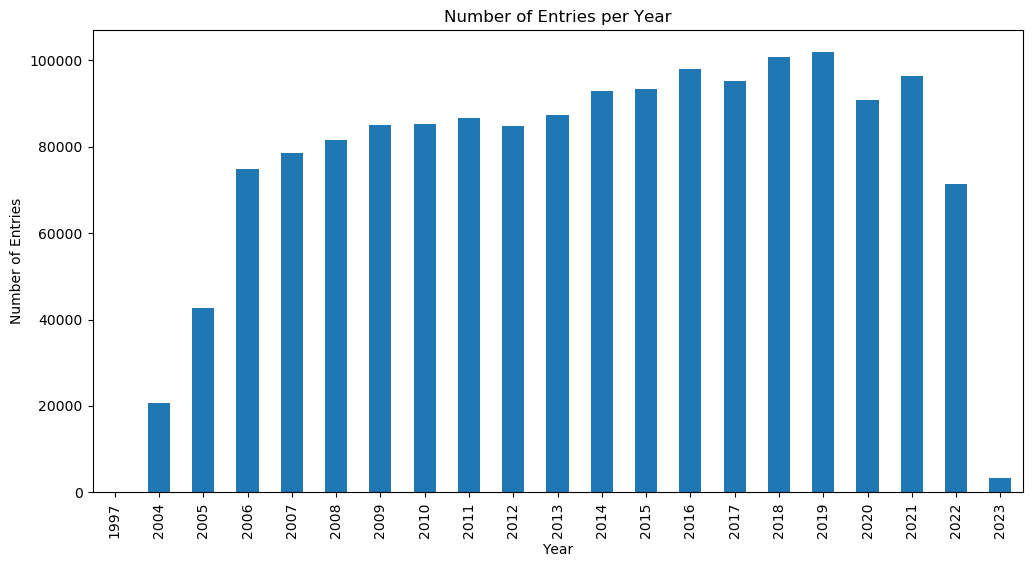

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'RestingECG_TestDemographics_AcquisitionDate' column to datetime
df_2_grouped['RestingECG_TestDemographics_AcquisitionDate'] = pd.to_datetime(df_2_grouped['RestingECG_TestDemographics_AcquisitionDate'])

# Extract the year and count the number of entries per year
entries_per_year = df_2_grouped['RestingECG_TestDemographics_AcquisitionDate'].dt.year.value_counts()

# Sort the years
entries_per_year = entries_per_year.sort_index()

# Plot the number of entries per year
entries_per_year.plot(kind='bar', figsize=(12,6))

plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Year')
plt.show()

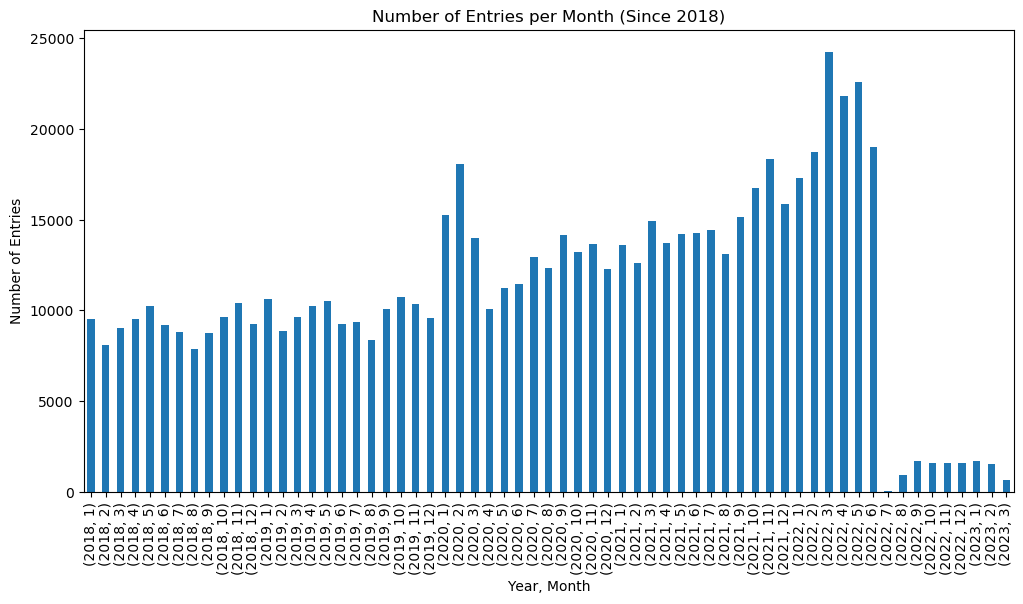

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'RestingECG_TestDemographics_AcquisitionDate' column to datetime
df_2['RestingECG_TestDemographics_AcquisitionDate'] = pd.to_datetime(df_2['RestingECG_TestDemographics_AcquisitionDate'])

# Filter the dataframe for entries since 2018
df_2 = df_2[df_2['RestingECG_TestDemographics_AcquisitionDate'].dt.year >= 2018]

# Create new columns for year and month
df_2['Year'] = df_2['RestingECG_TestDemographics_AcquisitionDate'].dt.year
df_2['Month'] = df_2['RestingECG_TestDemographics_AcquisitionDate'].dt.month

# Group by year and month, and count the number of entries
entries_per_month = df_2.groupby(['Year', 'Month']).size()

# Plot the number of entries per month for each year
entries_per_month.plot(kind='bar', figsize=(12,6))

plt.xlabel('Year, Month')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Month (Since 2018)')
plt.show()

In [6]:
# df_output['ecg_abnormal'] = np.where(df_output['Diagnosis'].str.contains('ECG anormal'), 1, np.where(df_output['Diagnosis'].str.contains('ECG normal'), 0, -1))
# Remove ECG anormal and ECG normal from diagnosis
# df_output['Diagnosis'] = df_output['Diagnosis'].str.replace('ECG anormal', '')
# df_output['Original_Diagnosis'] = df_output['Original_Diagnosis'].str.replace('ECG normal', '')
# df_output['Original_Diagnosis'] = df_output['Diagnosis'].str.replace('ECG anormal', '')
# df_output['Diagnosis'] = df_output['Original_Diagnosis'].str.replace('ECG normal', '')
# df_output.to_csv('data/20221002_ECG_mod_diagnosis.csv')

In [ ]:
df_m = (
    df_output.groupby(["patientid", "AcquisitionDate", "AcquisitionTime"])
    .first()
    .reset_index()
)
display(df_stats(df_output))
display(df_stats(df_m))
## The ECGs can be grouped by patient id, date and time to have a 1 unique row per ECG - this means the filename to save the ECG also needs to have the date and time in it.

In [ ]:
# output_dir = os.getcwd() + '/ekg_waveforms_output/'
# ekg_batch_run(df['path'][0:1])

###  Run CLI_xml2df by Alexis to generate NUMPY ARRAYS and SAVE dataset as PARQUET

In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


import os

os.environ["R_HOME"] = "/root/miniconda3/envs/R/lib/R"

import rpy2.robjects as objects
from rpy2.robjects.packages import importr

base = importr("base")
r_pROC = importr("pROC")
base._libPaths()[0]


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(
        list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"]
    )
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_140797/1622204394.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [14]:
df = pd.read_csv("data/20230313_ECG_path.csv")

In [ ]:
import CLI_xml2df as xml2df

df_output = xml2df.tinyxml2df(
    df["path"], out_path="data/ekg_waveforms_output/"
).read2flatten()

Transforming xml files into dict:   0%|                                                                                                                                                                      | 46/1633856 [00:06<31:43:21, 14.31it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799999', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:30:57', 'AcquisitionDate': '11-01-2021', 'EditTime': '10:57:44', 'EditDate': '11-02-2021', 'OverreaderID': '20001', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '21109084', '

Transforming xml files into dict:   0%|                                                                                                                                                                     | 1086/1633856 [00:36<8:55:36, 50.81it/s]

In [ ]:
#df_output.to_csv('data/20230328_ECG_path_diagnosis_fixed_with_NPY.csv')

In [62]:
df_output.to_parquet(
    "/media/data1/ravram/DeepECG/ekg_waveforms_output/df_xml_2023_03_30_n_1633856.parquet"
)

In [ ]:
npy_array = np.load(df_output["npy_path"][0])
# Transpose the array to shape=[12, 2500]
ecg_transposed = np.transpose(npy_array, (1, 0, 2))
ecg_transposed = ecg_transposed.reshape(12, 2500)

import ecg_plot

ecg_plot.plot(ecg_transposed, sample_rate=250, title="ECG 12")
ecg_plot.show()

In [ ]:
## Plot line of ecg_transposed[0] and ecg_transposed[1]
import matplotlib.pyplot as plt

plt.plot(ecg_transposed[0])
plt.plot(ecg_transposed[1])
plt.show()

### Propagate diagnoses labels

In [4]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_199451/2575175134.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [5]:
import re

import pandas as pd
from unidecode import unidecode


def normalize_string(s):
    s = unidecode(s)
    s = s.strip()
    s = re.sub(r"\W+", " ", s)
    return s


def contains_eligible_diagnosis(normalized_diag, eligible_diagnoses):
    # Initialize a variable to store the longest diagnosis and its length
    longest_diagnosis = None
    longest_length = 0

    # Iterate over eligible_diagnoses
    for diagnosis in eligible_diagnoses:
        # Check if diagnosis is in normalized_diag
        if diagnosis in normalized_diag:
            # Check if the length of the current diagnosis is greater than the current longest_length
            if len(diagnosis) > longest_length:
                # Update the longest_diagnosis and longest_length
                longest_diagnosis = diagnosis
                longest_length = len(diagnosis)
                
    if (longest_diagnosis != None):
        # Return the longest_diagnosis
        return longest_diagnosis
    else:
        return False


def filter_ecg_by_diagnosis(df_ecg, df_ecg_sampled):
    df_ecg["Normalized_Diagnosis_MUSE"] = df_ecg["diagnosis"].apply(normalize_string)
    df_ecg_sampled["Normalized_Diagnosis_LABELBOX"] = df_ecg_sampled["Original_Diagnosis"].apply(
        normalize_string
    )

    eligible_diagnoses = set(df_ecg_sampled["Normalized_Diagnosis_LABELBOX"])

    df_ecg["Normalized_Diagnosis_LABELBOX"] = df_ecg["Normalized_Diagnosis_MUSE"].apply(
        lambda x: contains_eligible_diagnosis(x, eligible_diagnoses)
    )

    return df_ecg

In [6]:
df_ecg = pd.read_parquet(
    "/media/data1/ravram/DeepECG/ekg_waveforms_output/df_xml_2023_03_30_n_1633856.parquet"
)

In [7]:
# Replace the folder path in the npy_path column
#df_ecg['npy_path'] = df_ecg['npy_path'].replace(
#    r'data/ekg_waveforms_output/ecg_npy/', 
#    '/media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/', 
#    regex=True
#)

In [8]:
import os
# Check if df_ecg['npy_path'] exists
display(df_ecg.npy_path)#
df_ecg[0:10000]['npy_path'].apply(lambda x: os.path.exists(x)).value_counts()

0          /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0526715_02-27-2023_10-09-16.npy
1          /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0621370_02-23-2023_11-13-00.npy
2          /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0337660_02-24-2023_09-36-41.npy
3          /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0799999_08-19-2021_14-15-00.npy
4          /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0609083_06-22-2022_22-51-54.npy
                                                     ...                                           
1633851    /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0267493_02-24-2023_08-20-41.npy
1633852    /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0057447_02-24-2023_13-04-00.npy
1633853    /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0370321_02-26-2023_07-34-35.npy
1633854    /media/data1/ravram/DeepECG/ekg_waveforms_output/ecg_npy/0621452_02-25-2023_10-08-51.npy


True     9999
False       1
Name: npy_path, dtype: int64

In [12]:
df_ecg_sampled = pd.read_csv("data/20221002_ECG_mod_diagnosis_sampled_3600.csv")
df_ecg_sampled = df_ecg_sampled.groupby(['Diagnosis']).first()
display(df_ecg_sampled.describe())

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,patientid,age,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAXis,TAxis,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,ECGSampleExponent,QTcFrederica,Location,ecg_abnormal
count,1680.000000,1680.000000,1680.000000,1.680000e+03,1680.000000,1680.000000,1628.000000,1305.000000,1680.000000,1680.000000,1680.000000,1331.000000,1680.000000,1680.000000,1679.000000,1679.000000,1679.000000,1325.000000,1325.000000,1679.000000,1680.0,1680.0,1680.000000,1680.000000,1680.000000
mean,1679.000000,98686.894048,98686.894048,4.036973e+05,68.342857,74.857738,91.729730,178.607663,107.202381,411.392262,449.937500,49.087904,10.293452,57.289286,12.306730,215.051817,268.653365,126.917736,179.017358,420.769506,500.0,0.0,436.216071,28.875000,-0.957738
std,970.237084,64830.463391,64830.463391,2.271023e+05,14.812598,20.066432,67.326581,44.666239,28.660914,50.489495,42.375547,32.418257,54.139939,65.198316,3.315639,9.380847,11.613775,22.998326,23.191483,24.167766,0.0,0.0,38.529527,15.757161,0.201246
min,0.000000,31.000000,31.000000,2.636000e+03,15.000000,38.000000,23.000000,32.000000,56.000000,162.000000,241.000000,-89.000000,-89.000000,-89.000000,6.000000,159.000000,249.000000,8.000000,58.000000,301.000000,500.0,0.0,211.000000,0.000000,-1.000000
25%,839.500000,42013.250000,42013.250000,2.547490e+05,60.000000,61.000000,61.000000,152.000000,88.000000,380.000000,422.000000,33.000000,-27.000000,15.000000,10.000000,212.000000,261.000000,116.000000,168.000000,406.000000,500.0,0.0,412.000000,21.000000,-1.000000
50%,1679.000000,92174.000000,92174.000000,4.332045e+05,70.000000,71.000000,72.000000,170.000000,98.000000,410.000000,445.000000,50.000000,5.000000,48.000000,12.000000,217.000000,265.000000,131.000000,184.000000,420.000000,500.0,0.0,431.000000,25.000000,-1.000000
75%,2518.500000,147548.500000,147548.500000,5.773622e+05,79.000000,84.000000,88.000000,196.000000,122.000000,442.000000,473.000000,64.000000,40.000000,91.000000,14.000000,221.000000,273.000000,142.000000,194.000000,436.000000,500.0,0.0,457.000000,42.000000,-1.000000
max,3358.000000,233701.000000,233701.000000,5.995598e+06,98.000000,211.000000,625.000000,480.000000,248.000000,648.000000,723.000000,268.000000,270.000000,270.000000,35.000000,243.000000,339.000000,173.000000,223.000000,533.000000,500.0,0.0,662.000000,53.000000,0.000000


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def save_ecg_plots(df_output_sampled, output_dir, diagonsis_column='diagnosis', figsize=(16, 9), dpi=300, lead_order=None):
    if lead_order is None:
        lead_order = [
            "I",
            "II",
            "III",
            "aVR",
            "aVL",
            "aVF",
            "V1",
            "V2",
            "V3",
            "V4",
            "V5",
            "V6",
        ]

    path_to_output = os.path.join(os.getcwd(), output_dir)
    
    if not os.path.exists(path_to_output):
        os.mkdir(path_to_output)

    for index, row in tqdm(df_output_sampled.iterrows()):
        path = os.path.join(row["npy_path"])
        file = np.load(path)
        file = np.reshape(file, (1, 2500, 12))

        plt.rcParams["figure.figsize"] = figsize
        plt.ioff()
        fig, axs = plt.subplots(len(lead_order))
        
        for i in range(12):
            if i == 0:
                axs[i].set_title(row[diagonsis_column])
            axs[i].plot(file[0][:, i])
            axs[i].set(ylabel=str(lead_order[i]))

        AcquisitionDateTime = row["RestingECG_TestDemographics_AcquisitionDate"] + "_" + row["RestingECG_TestDemographics_AcquisitionTime"].replace(":", "-")
        filename = f"{row['RestingECG_PatientDemographics_PatientID']}_{AcquisitionDateTime}.png"
        
        file_output = os.path.join(path_to_output, filename)
        print(file_output)
        
        plt.savefig(file_output, dpi=dpi, bbox_inches="tight")
        plt.close(fig)

In [14]:
#save_ecg_plots(df_f[6511:6513], output_dir="sanity_check/")

In [15]:
pd.options.display.max_colwidth = 1000

In [21]:
df_f = filter_ecg_by_diagnosis(df_ecg, df_ecg_sampled)

In [22]:
## Apply this if the "Contains_Eligible_Diagnosis" is not FALSE; if it is false, return 0
df_f['percentage_labelbox_string_present_in_original_string'] = df_f.apply(lambda x: len(x['Normalized_Diagnosis_LABELBOX'])/len(x['diagnosis']) if x['Normalized_Diagnosis_LABELBOX'] != False else 0, axis=1)

In [23]:
display(df_f.percentage_labelbox_string_present_in_original_string.describe())

count    1.633856e+06
mean     7.451362e-01
std      3.086749e-01
min      0.000000e+00
25%      5.930736e-01
50%      8.636364e-01
75%      1.000000e+00
max      1.000000e+00
Name: percentage_labelbox_string_present_in_original_string, dtype: float64

In [33]:
df_f['Normalized_Diagnosis_LABELBOX'] = df_f['Normalized_Diagnosis_LABELBOX'].astype(str)
df_f = df_f.drop(['RestingECG_PatientDemographics_PatientFirstName'], axis=1)
df_f = df_f.drop(['RestingECG_PatientDemographics_PatientLastName'], axis=1)

In [35]:
df_f.to_parquet(
    "/media/data1/ravram/DeepECG/ekg_waveforms_output/df_xml_2023_03_30_n_1633856_with_labelbox.parquet"
)

In [ ]:
### 1) Voir quelles données labelbox sont discordantes et me les envoyer pour annotation (et enlever ces ECG de la base de données)
### 2) Faire propagation des données labelbox concordantes sur df_ecg (db. parquet)
### 3) Dictionnaire pour df_ecg['Contains_Eligible_Diagnosis']==False
### 4) Standardiser le dataloader